In [16]:
#Importing the necessary modules for this project
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
#Merging all our data into one dataset, all_data

data1, data2 = pd.read_csv("Data1.csv"), pd.read_csv("Data2.csv")
all_data = data1.merge(data2, how='inner',on='ID')
print(all_data.shape)

(5000, 14)


In [18]:
#Dropping the 'ID' column because it is unnecessary for binary classification predictions

all_data = all_data.drop(columns='ID')
all_data.shape

(5000, 13)

In [19]:
#Checking the null points in our data, we have 20 training examples with null target values

all_data.isnull().sum()

Age                     0
CustomerSince           0
HighestSpend            0
ZipCode                 0
HiddenScore             0
MonthlyAverageSpend     0
Level                   0
Mortgage                0
Security                0
FixedDepositAccount     0
InternetBanking         0
CreditCard              0
LoanOnCard             20
dtype: int64

In [20]:
#Dropping the null training examples and rechecking the data shape

all_data = all_data.dropna()
all_data.shape

(4980, 13)

<Axes: xlabel='LoanOnCard', ylabel='count'>

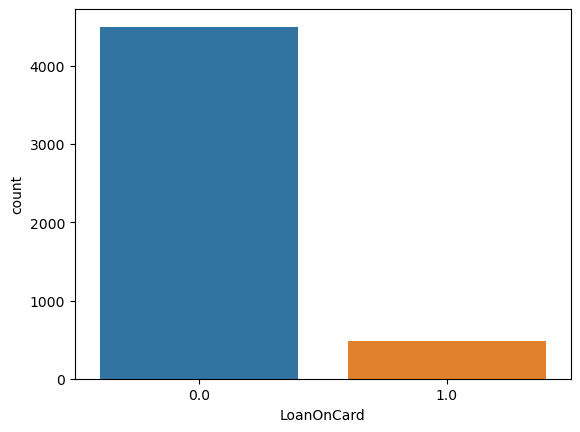

In [21]:
#Checking the frequency of ground true labels using EDA

sns.countplot(x='LoanOnCard', data=all_data)

In [22]:
#Checking percentage distribution of ground true labels. We can see that the data is imbalanced towards false target labels.

true_label = len(all_data.loc[all_data['LoanOnCard']==1])
false_label = len(all_data.loc[all_data['LoanOnCard']==0])

true_label_percentage, false_label_percentage = (true_label / all_data.shape[0]) * 100, (false_label / all_data.shape[0]) * 100

print("TRUE labels: {true} ({true_percent:.2f}%)".format(true = true_label, true_percent = true_label_percentage))
print("FALSE labels: {false} ({false_percent:.2f}%)".format(false = false_label, false_percent = false_label_percentage))

TRUE labels: 480 (9.64%)
FALSE labels: 4500 (90.36%)


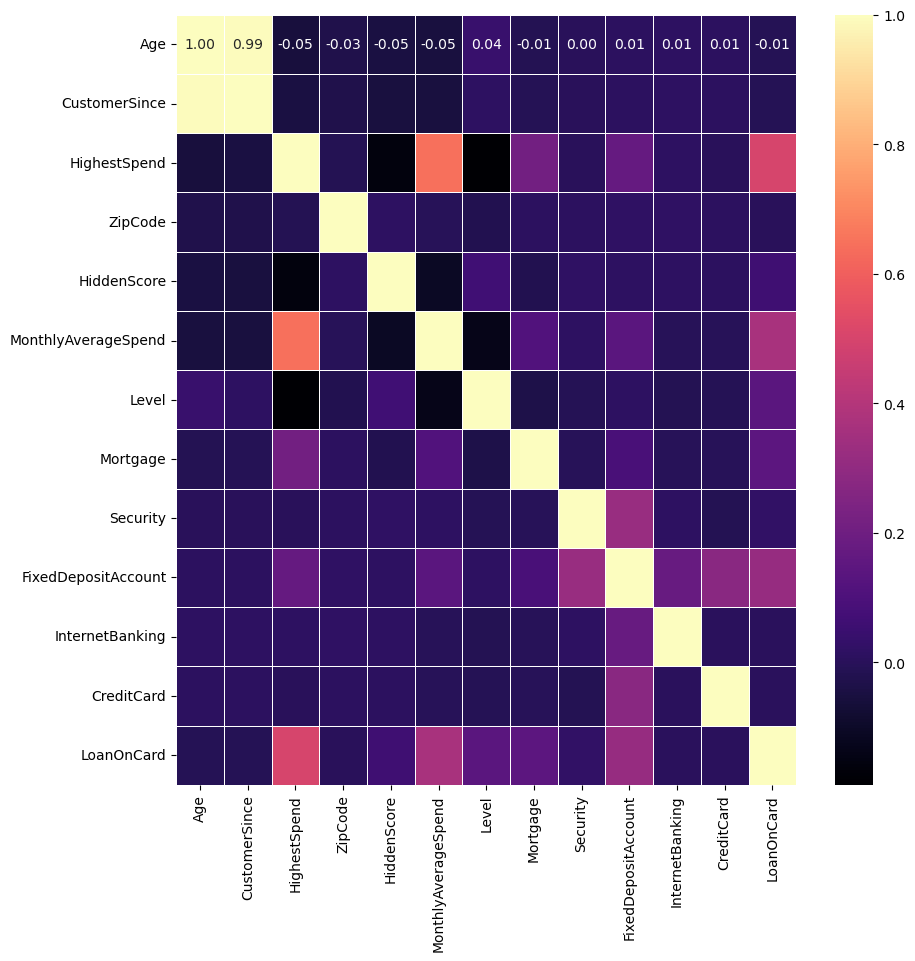

In [23]:
#Checking correlation in data using a heatmap.

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(all_data.corr(), ax = ax, annot=True, linewidths=0.5, fmt='.2f', cmap='magma')
plt.show()

In [24]:
#We can see from the heatmap that Age and Customer Since have high correlation with one another so we need to drop one.
#We can also see that Zip code has no correlation with any other variable, meaning it has no effect on the ground true label.

all_data = all_data.drop(columns='Age')
all_data = all_data.drop(columns='ZipCode')
all_data.shape

(4980, 11)

In [25]:
#Splitting the data into training and testing sets for classification. Our training/testing split will be 70/30.

from sklearn.model_selection import train_test_split

Y = all_data['LoanOnCard']
X = all_data.drop(columns='LoanOnCard')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [28]:
#Creating the logistic regression model of our data, training it in our training set, and then predicting our test set with it
#We import multiple parameters for accuracy that we will evaluate further

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

model = LogisticRegression(solver='liblinear')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
model_score = model.score(x_test, y_test)

In [35]:
#Evaluating Various Metrics:

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Recall Score: {recall_score(y_test, y_pred)}')
print(f'Precision Score: {precision_score(y_test, y_pred)}')
print(f'F1 Score: {f1_score(y_test, y_pred)}')

Accuracy: 0.9451137884872824
Confusion Matrix: 
[[1326   15]
 [  67   86]]
Recall Score: 0.5620915032679739
Precision Score: 0.8514851485148515
F1 Score: 0.6771653543307087


###### Evaluating the metrics, we can see that the model has an accuracy of approximately 94.5%. 
###### The confusion matrix shows 15 misclassified as a Type I error (15 false positive classifications) and 67 misclassified as a Type II error (67 false negative)
###### The precision score is 85% (out of all positive predictions, 85% were true positive) The recall score is 56% (out of all positive ground true values, 56% were predicted positive)


## We can add weight to the true predictions to reduce the Type II error of false negative classifications:

In [36]:
# We know that the data is skewed in favor of false labels, with about a 9:1 ratio:
print("TRUE labels: {true} ({true_percent:.2f}%)".format(true = true_label, true_percent = true_label_percentage))
print("FALSE labels: {false} ({false_percent:.2f}%)".format(false = false_label, false_percent = false_label_percentage))

TRUE labels: 480 (9.64%)
FALSE labels: 4500 (90.36%)


In [37]:
#Adding weights to account for this imbalance:

weight = {0:1, 1:9}
w_model = LogisticRegression(solver='liblinear',class_weight=weight)
w_model.fit(x_train, y_train)
y_pred_w = w_model.predict(x_test)
w_model_score = w_model.score(x_test,y_test)

In [43]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_w)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_w)}')
print(f'Recall Score: {recall_score(y_test, y_pred_w)}')
print(f'Precision Score: {precision_score(y_test, y_pred_w)}')
print(f'F1 Score: {f1_score(y_test, y_pred_w)}')

Accuracy: 0.8888888888888888
Confusion Matrix: 
[[1194  147]
 [  19  134]]
Recall Score: 0.8758169934640523
Precision Score: 0.47686832740213525
F1 Score: 0.6175115207373272


##### Weighting the predictions this way vastly increases our recall score, but subsequently reduces the precision score. The accuracy of the model has also decreased to 88.88%

## We can use an SVM to leverage Kernel non-linearity and avoid potential outliers in the data:

In [44]:
#SVM implementation for classification:

from sklearn import svm

svm_model = svm.SVC(gamma=0.25, C=10)
svm_model.fit(x_train, y_train)
y_predict_svm = svm_model.predict(x_test)

In [45]:
print(f'Accuracy: {accuracy_score(y_test, y_predict_svm)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_predict_svm)}')
print(f'Recall Score: {recall_score(y_test, y_predict_svm)}')
print(f'Precision Score: {precision_score(y_test, y_predict_svm)}')
print(f'F1 Score: {f1_score(y_test, y_predict_svm)}')

Accuracy: 0.8989290495314591
Confusion Matrix: 
[[1337    4]
 [ 147    6]]
Recall Score: 0.0392156862745098
Precision Score: 0.6
F1 Score: 0.0736196319018405
